## Programming Exercise 4: Neural Networks Learning
#### Author - Rishabh Jain

In [1]:
import warnings
warnings.simplefilter('ignore')

import os,glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image,ImageFilter
%matplotlib inline

from scipy.io import loadmat

#### Learning Resources

1. [What is a Neural Network??](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
2. [Gradient Descent, how neural networks learn?](https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=2)
3. [What is Backpropagation really doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=3)
4. [Backpropagation Calculus](https://www.youtube.com/watch?v=tIeHLnjs5U8&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=4)

### 1&nbsp;&nbsp;&nbsp;&nbsp;Neural Networks

##### Problem Statement
In the previous exercise, we implemented feedforward propagation for neural networks and used it to predict handwritten digits with the provided weights. **In this exercise, we will implement the backpropagation algorithm to learn the parameters for the neural network.**

We will use the same dataset that we used in the previous exercise. There are 5000 training examples, where each example is 20 X 20 pixel image of a handwritten digit. Each pixel is represented by a floating point number indicating the graysacle intensity at that location. This 20 by 20 grid of pixels is 'unrolled' into a 400 dimensional vector.

In [2]:
# Loading Mat file
mat=loadmat('./ex4data1.mat')
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
y


In [3]:
# Loading data from mat to Dataframe
m,n=mat['X'].shape

data=pd.DataFrame()
for i in range(n):
    data[f'x{i+1}']=mat['X'][:,i]

# Converting label 10 to label 0
data['y']=mat['y']
data.loc[data['y']==10,'y']=0

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
data.sample(5)

TRAINING DATASET SHAPE : 5000 X 401


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x392,x393,x394,x395,x396,x397,x398,x399,x400,y
3995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Visualizing the data

We will begin by visualizing a subset of the training set. We will randomly select 100 rows from X. This function maps each row to a 20 X 20 pixel image and displays together.

In [4]:
def displayData(X):
    m,n=X.shape
    width=int(np.sqrt(n))
    height=int(n/width)
    rows=int(np.floor(np.sqrt(m)))
    cols=int(np.ceil(m/rows))
    totalWidth=cols+cols*width
    displayArray=np.zeros((1,totalWidth))
    rowPadding=np.ones((1,totalWidth))
    colPadding=np.ones((height,1))
    index=0
    for i in range(rows):
        row=colPadding*0
        for j in range(cols):
            if index<m:
                x=X[index].reshape((width,height)).T
                index=index+1
            else:
                x=np.zeros((width,height)).T
            row=np.column_stack((row,x))
            if j<cols-1:
                row=np.column_stack((row,colPadding))
        displayArray=np.row_stack((displayArray,row))
        if i<rows-1:
            displayArray=np.row_stack((displayArray,rowPadding))
    displayArray=np.row_stack((displayArray,rowPadding*0))
    plt.imshow(displayArray,cmap='gray')
    plt.axis('off')

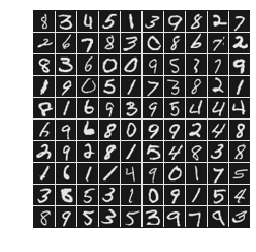

In [5]:
displayData(data.sample(100).iloc[:,:-1].values)

#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;Model Representation

<table>
    <tr>
        <td>
            <img src="images/neuron.png" width="300">
        </td>
        <td>
            <img src="images/nn.png" width="300">
        </td>
    </tr>
</table>

$a_i^{(j)}=$ "activation" of unit $i$ in layer $j$  
$\theta^{(j)}=$ matrix of weights controlling function mapping from layer $j$ to layer $j+1$  
$g(z)=$ sigmoid activation function  

$$ g(z)=\frac{1}{1+e^{(-z)}} $$

**If network has $s_j$ units in layer $j$, $s_{j+1}$ units in layer $j+1$, then $\theta^{(j)}$ will be of dimension** $s_{j+1}$ X $(s_j+1)$

$$ a^{(2)}_1=g(\theta_{10}^{(1)}x_0+\theta_{11}^{(1)}x_1+\theta_{12}^{(1)}x_2+\theta_{13}^{(1)}x_3) $$

$$ a^{(2)}_2=g(\theta_{20}^{(1)}x_0+\theta_{21}^{(1)}x_1+\theta_{22}^{(1)}x_2+\theta_{23}^{(1)}x_3) $$

$$ a^{(2)}_3=g(\theta_{30}^{(1)}x_0+\theta_{31}^{(1)}x_1+\theta_{32}^{(1)}x_2+\theta_{33}^{(1)}x_3) $$

#### 1.3&nbsp;&nbsp;&nbsp;&nbsp;Feedforward and cost function

**Feed Forward**  
$$ z^{(i)}=\theta^{(i-1)}a^{(i-1)} $$
$$ a^{(i)}=g(z^{(i)}) $$

**Cost function** for a Neural Network is very similar to logistic regression except that the cost is summed over all the K classes.

$$ J(\theta)=\frac{-1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}[y_k^{(i)}log(h_\theta(x^{(i)})_k)+(1-y_k^{(i)})log(1-h_\theta(x^{(i)})_k)] $$ 

#### 1.4&nbsp;&nbsp;&nbsp;&nbsp;Regularized cost function

We should not be regularizing the terms that corresponds to the bias term. For the matrices $\theta^{(1)}$ and $\theta^{(2)}$, this corresponds to the first column of each matrix. The cost function for neural networks with regularization is given by:

$$ J(\theta)=\frac{-1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}[y_k^{(i)}log(h_\theta(x^{(i)})_k)+(1-y_k^{(i)})log(1-h_\theta(x^{(i)})_k)] + \frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_{l}}\sum_{j=1}^{s_{l}+1}(\theta_{ij^{(l)}})^2$$ 



### 2&nbsp;&nbsp;&nbsp;&nbsp;Backpropagation

In this part of the exercise , we will implement the **backpropagation algorithm to compute the gradient for the neural network cost function.** Once we have computed the gradient, we will then be able to train the neural network by minimizing the cost function $J(\theta)$ using gradient descent.

#### 2.1&nbsp;&nbsp;&nbsp;&nbsp;Sigmoid gradient

Now, let's understand the derivation for gradient of sigmoid function:

$ \frac{\partial}{\partial{x}}(\frac{1}{1+e^{-z}}) = \frac{(1+e^{-z})\frac{\partial{(1)}}{\partial{x}}-1\frac{\partial{(1+e^{-z}})}{\partial{}x}}{(1+e^{-z})^2} $

$ \;\;\;\;\;\;\;\;\;\;\;\;\;\;= \frac{e^{-z}}{(1+e^{-z})^2} $

Adding & subtracting 1 from numerator,

$ \;\;\;\;\;\;\;\;\;\;\;\;\;\;= \frac{1+e^{-z}-1}{(1+e^{-z})^2} $

$ \;\;\;\;\;\;\;\;\;\;\;\;\;\;= \frac{1+e^{-z}}{(1+e^{-z})^2}-\frac{1}{{(1+e^{-z})^2}} $

$ \;\;\;\;\;\;\;\;\;\;\;\;\;\;= g(z)-g(z)^{(2)} $

$$ \boxed{g'(z)=g(z)(1-g(z))}\;\;\;\;\;\;\;(1) $$ 

In [6]:
def sigmoid(z):
    sigma=1/(1+np.exp(-z))
    return sigma

In [7]:
def sigmoidGradient(z):
    g=np.multiply(sigmoid(z),(1-sigmoid(z)))
    return g

In [8]:
sigmoidGradient(0)

0.25

#### 2.2&nbsp;&nbsp;&nbsp;&nbsp;Random initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\theta^{(l)}$ uniformly in the range of $[-\epsilon_{init},+\epsilon_{init}]$

$$ \epsilon_{init}=\frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}} $$

,where $L_{in}$ & $L_{out}$ are the number of neurons in input and output layer respectively. This range of values ensures that the parameters are kept small and makes the learning more efficeint.

**Note : Parameters should not be initialized to zero because they will remain zero for all iterations.**

In [9]:
def randInitializeWeights(lIn,lOut):
    '''Randomly initialize the weights with a matix of shape lOut X (lIn+1)'''
    epsilonInit=np.sqrt(6)/np.sqrt(lIn+lOut)
    W=np.random.rand(lOut,lIn+1)*2*epsilonInit-epsilonInit
    return W

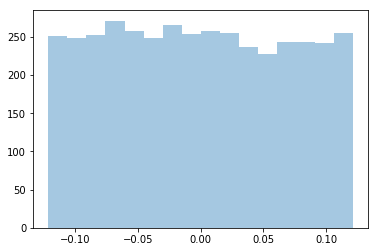

In [10]:
lIn=400
lOut=10

w=randInitializeWeights(lIn,lOut).reshape(-1).tolist()
sns.distplot(w,kde=False);

#### 2.3&nbsp;&nbsp;&nbsp;&nbsp;Backpropagation

Given an input $X$, output $h_{\theta}(x)$ is determined by $\theta^{(1)}$, $\theta^{(2)}$, $\theta^{(3)}$ ... $\theta^{(n)}$. To reduce the error $J(\theta)$ we have to change the weights $\theta_i$ using gradient descent update rule. For the update rule we would need to compute gradient using backpropagation alogrithm.

$$ \theta^{(l)}=\theta^{(l)}-\alpha\frac{\partial{J}}{\partial{\theta^{(l)}}} $$

<img src="images/nn2.png" width="400">

**Mathematical derivation** 

For a neural network, we can say that the **change in $J(\theta)$ $w.r.t$ $\theta$ results from a change in $z$ (sum of the product of input and parameter) which in turn changes $a$ (activation) which eventually changes $J$**. This relationship for an above neural network can be written as a chain rule in calculus like this :

$ \frac{\partial{J}}{\partial{\theta^{(3)}}} = \frac{\partial{J}}{\partial{a^{(4)}}}\frac{\partial{a^{(4)}}}{\partial{z^{(4)}}}\frac{\partial{z^{(4)}}}{\partial{\theta^{(3)}}} $  

Replacing $\frac{\partial{J}}{\partial{a^{(4)}}}=(a^{(4)}-y)$ and $z^{(4)}$ and $a^{(4)}$ using feed forward expressions, we get

$ \;\;\;\;\;\;\;=(a^{(4)}-y)\frac{\partial{g(z^{(4)})}}{\partial{z^{(4)}}}\frac{\partial{(\theta^{(3)}a^{(3)}})}{\partial{\theta^{(3)}}} $

$ \;\;\;\;\;\;\;=(a^{(4)}-y)g'(z^{(4)})a^{(3)} $

$ \boxed{\frac{\partial{J}}{\partial{\theta^{(3)}}} =\delta^{(4)}a^{(3)}} \;\;\;\;\;\;\;$ where,  $\boxed{\delta^{(4)}=(a^{(4)}-y)g'(z^{(4)})}\;\;\;\;\;\;\; $ (2) & (3)

Similarly, computing

$ \frac{\partial{J}}{\partial{\theta^{(2)}}} = \frac{\partial{J}}{\partial{a^{(4)}}}\frac{\partial{a^{(4)}}}{\partial{z^{(4)}}}\frac{\partial{z^{(4)}}}{\partial{a^{(3)}}}\frac{\partial{a^{(3)}}}{\partial{z^{(3)}}}\frac{\partial{z^{(3)}}}{\partial{\theta^{(2)}}} $  

Using equation (2) & (3)

$ \;\;\;\;\;\;\;=(a^{(4)}-y)g'(z^{(4)})\frac{\partial{(\theta^{(3)}a^{(3)}})}{\partial{a^{(3)}}}\frac{\partial{g(z^{(3)})}}{\partial{z^{(3)}}}\frac{\partial{(\theta^{(2)}a^{(2)}})}{\partial{\theta^{(2)}}} $

$ \;\;\;\;\;\;\;=(a^{(4)}-y)g'(z^{(4)})\theta^{(3)}g'(z^{(3)})a^{(2)} $

$ \;\;\;\;\;\;\;=\delta^{(4)}\theta^{(3)}g'(z^{(3)})a^{(2)} $

$ \boxed{\frac{\partial{J}}{\partial{\theta^{(2)}}} =\delta^{(3)}a^{(2)}} \;\;\;\;\;\;\;$ where,  $\boxed{\delta^{(3)}=\theta^{(3)}\delta^{(4)}g'(z^{(3)})}\;\;\;\;\;\;\; $ (4) & (5)

Similarly, computing for 

$ \frac{\partial{J}}{\partial{\theta^{(1)}}} = \frac{\partial{J}}{\partial{a^{(4)}}}\frac{\partial{a^{(4)}}}{\partial{z^{(4)}}}\frac{\partial{z^{(4)}}}{\partial{a^{(3)}}}\frac{\partial{a^{(3)}}}{\partial{z^{(3)}}}\frac{\partial{z^{(3)}}}{\partial{a^{(2)}}}\frac{\partial{a^{(2)}}}{\partial{z^{(2)}}}\frac{\partial{z^{(2)}}}{\partial{\theta^{(1)}}} $  

Using equation (2),(3),(4) & (5)

$ \;\;\;\;\;\;\;=(a^{(4)}-y)g'(z^{(4)})\theta^{(3)}g'(z^{(3)})\frac{\partial{(\theta^{(2)}a^{(2)}})}{\partial{a^{(2)}}}\frac{\partial{g(z^{(2)})}}{\partial{z^{(2)}}}\frac{\partial{(\theta^{(1)}a^{(1)})}}{\partial{\theta^{(1)}}} $

$ \;\;\;\;\;\;\;=(a^{(4)}-y)g'(z^{(4)})\theta^{(3)}g'(z^{(3)})\theta^{(2)}g'(z^{(2)})a^{(1)} $

$ \;\;\;\;\;\;\;=\delta^{(4)}\theta^{(3)}g'(z^{(3)})\theta^{(2)}g'(z^{(2)})a^{(1)} $

$ \;\;\;\;\;\;\;=\delta^{(3)}\theta^{(2)}g'(z^{(2)})a^{(1)} $

$ \boxed{\frac{\partial{J}}{\partial{\theta^{(1)}}} =\delta^{(2)}a^{(1)}} \;\;\;\;\;\;\;$ where,  $\boxed{\delta^{(2)}=\theta^{(2)}\delta^{(3)}g'(z^{(2)})}\;\;\;\;\;\;\; $ (6) & (7)

From equation (1) & (3), we can conclude that the **'error' in output layer** is
> For Cross Entropy Function
$$ \boxed{\delta^L=(a^L-y)} $$
For Least Square Function
$$ \boxed{\delta^L=(a^L-y)(a^L)(1-a^L)} $$

From equation (1),(5) & (7), we can conclude that **'error' in hidden layers** is 

$$ \boxed{\delta^{(i)}=\theta^{(i)}\delta^{(i+1)}a^{(i)}(1-a^{(i)})} $$

From (2),(4) and (6), we can conclude that the **gradient** is 
$$ \boxed{\frac{\partial{J}}{\partial{\theta^{(i)}}}=\delta^{(i+1)}a^{(i)}} $$

**Backpropagation Algorithm Steps**

Training Set $\{(x^{(1)},y{(1)}),...,(x^{(m)},y{(m)})\}$  

Set $\Delta_{ij}^{(l)}=0$ (for all $l,i,j$)  

For $i=1$ to $m$

* Set $a^{(1)}=x^{(i)}$
* Perform forward propagation to compute $a^{(l)}$ for $l=2,3,...,L$
* Using $y^{(i)}$, compute $\delta^{(L)}=a^{(L)}-y^{(i)}$
* Compute $\delta^{(L-1)},\delta^{(L-2)},...,\delta^{(2)}$
* $\Delta_{ij}^{(l)}:=\Delta_{ij}^{(l)}+a_j^{(l)}\delta_i^{(l+1)}$

$D_{ij}^{(l)}:=\frac{1}{m}(\Delta_{ij}^{(l)}+\lambda\theta_{ij}^{(l)})$ if $j\neq0$  

$D_{ij}^{(l)}:=\frac{1}{m}(\Delta_{ij}^{(l)})$ if $j=0$

$ \boxed{\frac{\partial}{\partial{\theta_{ij}^{(l)}}}J(\theta)=D_{ij}^{(l)}} $

**Notes**
1. error ($\delta$) for input layer and bias node (neuron) is not calculated.
2. 'For loop' can be avoided by using Matrix Algebra.

In [11]:
def computeCost(X,y,params,inputLayerSize,hiddenLayerSize,lmbda):
    '''Computes the cost and the gradient using backpropagation for a 2 layered neural network'''
    m,n=X.shape
    numLabels=y.shape[1]
    # Reshape params into theta1 and theta2 matrices
    theta1=params[:,:hiddenLayerSize*(inputLayerSize+1)].reshape((hiddenLayerSize,inputLayerSize+1))
    theta2=params[:,hiddenLayerSize*(inputLayerSize+1):].reshape((numLabels,hiddenLayerSize+1))
    # Feed Forward Propogation
    a1=np.column_stack((np.ones(m),X))
    z2=np.dot(a1,theta1.T)
    a2=sigmoid(z2)
    a2=np.column_stack((np.ones(shape=(a2.shape[0],1)),a2))
    z3=np.dot(a2,theta2.T)
    a3=sigmoid(z3)
    h=a3
    # Computing cost
    J=(-1/m)*np.sum(np.multiply(y,np.log(h))+np.multiply(1-y,np.log(1-h)))
    # Adding regularization term
    J=J+(lmbda/(2*m))*(np.sum(np.power(theta1[:,1:],2))+np.sum(np.power(theta2[:,1:],2)))
    # Backpropagation
    # Calculating error for hidden and output layer
    delta3=h-y
    delta2=np.multiply(np.dot(delta3,theta2),np.multiply(a2,1-a2))[:,1:]
    # Calculating Gradient
    D2=np.dot(delta3.T,a2)
    D1=np.dot(delta2.T,a1)
    # Adding regularization term
    grad2=(1/m)*D2+(lmbda/m)*np.column_stack((np.zeros((theta2.shape[0],1)),theta2[:,1:]))
    grad1=(1/m)*D1+(lmbda/m)*np.column_stack((np.zeros((theta1.shape[0],1)),theta1[:,1:]))
    # Unroll gradients into one vector
    grad=grad1.reshape((1,-1))
    grad=np.column_stack((grad,grad2.reshape((1,-1))))
    return J,grad

**Calculating cost function for a neural network using the loaded set of parameters for $\theta^{(1)}$ and $\theta^{(2)}$**  

The neural network we are about to use has 3 layers - an input layer ($L_1$), a hidden layer ($L_2$) and an output layer ($L_3$). 
* L1 layer has 400 Neuron units (20 X 20 pixel image) excluding the extra bias unit that always output +1
* L2 layer has 25 Neuron units
* L3 layer has 10 Neuron Units

In [12]:
X=mat['X']
# One-hot encoding of target variable
y=pd.get_dummies(mat['y'].reshape(m)).values

# Loading weights
weights=loadmat('./ex4weights.mat')
theta1=weights['Theta1']
theta2=weights['Theta2']
params=theta1.reshape((1,-1))
params=np.column_stack((params,theta2.reshape((1,-1))))

inputLayerSize=400
hiddenLayerSize=25

print(f'X : {X.shape}')
print(f'y : {y.shape}')
print(f'Theta1 : {theta1.shape}')
print(f'Theta2 : {theta2.shape}')

X : (5000, 400)
y : (5000, 10)
Theta1 : (25, 401)
Theta2 : (10, 26)


In [13]:
lmbda=0
J,grad=computeCost(X,y,params,inputLayerSize,hiddenLayerSize,lmbda)
print(f'COST : {J:.4f}')

COST : 0.2876


In [14]:
lmbda=1
J,grad=computeCost(X,y,params,inputLayerSize,hiddenLayerSize,lmbda)
print(f'COST (with regularization): {J:.4f}')

COST (with regularization): 0.3838


#### 2.4&nbsp;&nbsp;&nbsp;&nbsp;Gradient checking

In our neural network we are minimizing $J(\theta)$. To perform gradient check, we can calculate the numerical gradient of $J(\theta)$ between two points ($\theta+\epsilon$,$J(\theta+\epsilon)$) and ($\theta-\epsilon$,$J(\theta-\epsilon)$) using two point slope formuale : $m=\frac{y_2-y_1}{x_2-x_1}$

$$ \frac{\partial}{\partial{\theta}}J(\theta) \approx \frac{J(\theta+\epsilon)-J(\theta-\epsilon)}{2\epsilon}$$

And then, we can compare the numerical gradient with the gradient calculated using backpropagation algorithm. The degree to which these 2 values should approximate each other is atleast 4 significant digits.

In [15]:
def computeNumericalGradient(J,theta):
    '''Computes the numerical gradient using two point slope equation'''
    numGrad=np.zeros(theta.shape)
    perturb=np.zeros(theta.shape)
    epsilon=1e-4
    for i in range(theta.size):
        perturb[:,i]=epsilon
        numGrad[:,i]=(J(theta+perturb)-J(theta-perturb))/(2*epsilon)
        perturb[:,i]=0
    return numGrad

In [16]:
def checkNNGradients(lmbda):
    '''Creates a small neural network to check the backpropagation gradients'''
    inputLayerSize=3
    hiddenLayerSize=5
    numLabels=3
    m=50
    # Generating some random test data
    theta1=randInitializeWeights(hiddenLayerSize,inputLayerSize)
    theta2=randInitializeWeights(numLabels,hiddenLayerSize)
    X=randInitializeWeights(inputLayerSize-1,m)
    y=1+np.mod(range(m),numLabels)
    # One-hot encoding target variable
    y=pd.get_dummies(y.reshape(m)).values
    # Unroll into vector
    thetas=theta1.reshape((1,-1))
    thetas=np.column_stack((thetas,theta2.reshape((1,-1))))
    # Gradient from backpropagation
    J,grad=computeCost(X,y,thetas,inputLayerSize,hiddenLayerSize,lmbda)
    # Computing numerical gradient
    def cost(thetas):
        J,grad=computeCost(X,y,thetas,inputLayerSize,hiddenLayerSize,lmbda)
        return J
    numGrad=computeNumericalGradient(cost,thetas)
    # Evaluating the norm of the differences between two solution
    diff=np.linalg.norm(numGrad-grad)/np.linalg.norm(numGrad+grad)
    return grad,numGrad,diff

Evaluating the norm of the difference between two solutions. If we have a correct implementation, then diff below should be less than 1e-9.

In [17]:
grad,numGrad,diff=checkNNGradients(0)
print(f'DIFFERENCE : {diff}')
pd.DataFrame(data={'grad (Backprop)':grad.reshape(-1),'grad (numerical)':numGrad.reshape(-1)})

DIFFERENCE : 2.6714672411876246e-10


,grad (Backprop),grad (numerical)
0,-0.017107,-0.017107
1,0.000841,0.000841
2,0.003656,0.003656
3,-0.006370,-0.006370
4,-0.045202,-0.045202
5,-0.000278,-0.000278
6,0.001342,0.001342
7,-0.002087,-0.002087
8,-0.018229,-0.018229
9,-0.002708,-0.002708


#### 2.5&nbsp;&nbsp;&nbsp;&nbsp;Regularized Neural Networks

After we have computed gradient using backpropagation, we should add regularization using  

$ \frac{\partial}{\partial{\theta_{ij}^{(l)}}}J(\theta)=D_{ij}^{(l)}:=\frac{1}{m}(\Delta_{ij}^{(l)}+\lambda\theta_{ij}^{(l)})$ if $j\neq0 $  

$ \frac{\partial}{\partial{\theta_{ij}^{(l)}}}J(\theta)=D_{ij}^{(l)}:=\frac{1}{m}(\Delta_{ij}^{(l)})$ if $j=0 $

Note that we should not be regularizing the first column of $\theta^{(l)}$ which is used for the bias term.$

#### 2.6&nbsp;&nbsp;&nbsp;&nbsp;Learning Parameters

NN Terminologies :

* **Epoch** : one forward pass and one backward pass of all the training examples.
* **Batch Size** : the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
* **# Iterations** : number of passes, each pass using batch size number of examples. To be clear, one pass = one forward pass + one backward pass.

In this part of the exercise, we will initialize our parameters randomly and train the neural network using gradient descent. There are three variants for Gradient Descent Algorithm listed below :

1. **Batch Gradient Descent** : In this variant, all the data is passed through the network. Gradients are calculated for the whole dataset to perform just one update. That means for one epoch, only 1 update occurs. This method is slower but accurate.


2. **Stochastic Gradient Descent** : Here, weights are updated after passing each data which means if our dataset has 1000 samples, one thousand updates will happen. This method is much faster but not that accurate.


3. **Mini-batch Gradient Descent** : This last variant tries to find a trade-off between the above two approaches. Here, we specify a batch size and we will update the weights after passing the data samples in each batch, means the gradients are calculated after passing each batch. Suppose we have dataset with 1000 records and we have specified a batch size of 100 data sample. In this case we will have 10 weight updates for each epoch. This method is more accurate than the second approach and much faster than the first approach.

In [18]:
def gradientDescent(X,y,inputLayerSize,hiddenLayerSize,alpha,lmbda,epoch,batchSize):
    m=X.shape[0]
    # One-hot encoding of target variable
    y=pd.get_dummies(y.reshape(-1)).values
    # Initializing parameters randomly
    labels=y.shape[1]
    theta1=randInitializeWeights(inputLayerSize,hiddenLayerSize)
    theta2=randInitializeWeights(hiddenLayerSize,labels)
    # Calculating iterations
    iterations=int(m/batchSize) if (m%batchSize==0) else int(m/batchSize)+1
    jHistory=[]
    for i in range(epoch):
        for j in range(iterations):
            # Setting start and end
            start=j*batchSize
            end=start+batchSize
            end=m if end>m else end
            # Unrolling into one vector
            params=theta1.reshape((1,-1))
            params=np.column_stack((params,theta2.reshape((1,-1))))
            # Computing cost and gradient
            J,grad=computeCost(X[start:end,:],y[start:end,:],params,inputLayerSize,hiddenLayerSize,lmbda)
            # Unrolling vector into grad matrices
            grad1=grad[:,:hiddenLayerSize*(inputLayerSize+1)].reshape((hiddenLayerSize,inputLayerSize+1))
            grad2=grad[:,hiddenLayerSize*(inputLayerSize+1):].reshape((labels,hiddenLayerSize+1))
            # Update rule
            theta1=theta1-alpha*grad1
            theta2=theta2-alpha*grad2
            jHistory.append(J)    
            print(f'EPOCH : {i+1}\tITERATIONS : {j+1}\t\tCOST : {J:.3f}',end='\r')
    df=pd.DataFrame({'Total Iterations':range(epoch*iterations),'Cost Function':jHistory})
    sns.lineplot(data=df,x='Total Iterations',y='Cost Function');
    return theta1,theta2

In [19]:
def predictNN(theta1,theta2,X):
    '''Predict the label of an input given a trained neural network'''
    m,n=X.shape
    # Feed Forward Propogation
    a1=np.column_stack((np.ones(m),X))
    z2=np.dot(a1,theta1.T)
    a2=sigmoid(z2)
    a2=np.column_stack((np.ones(shape=(a2.shape[0],1)),a2))
    z3=np.dot(a2,theta2.T)
    a3=sigmoid(z3)
    h=a3
    labels=h.argmax(axis=1)
    return labels.reshape((m,1))

In [20]:
def calculateAccuracy(h,y):
    '''Calculates the accuray between the target and prediction'''
    m=y.shape[0]
    unique,counts=np.unique(h==y,return_counts=True)
    dic=dict(zip(unique,counts))
    accuracy=(dic[True]/m)*100
    return accuracy

##### Splitting dataset into TRAIN and TEST set

In [21]:
data=data.sample(frac=1,random_state=43)

limit=4500
xTrain=data.values[:limit,:-1]
yTrain=data['y'].values[:limit].reshape((-1,1))
xTest=data.values[limit:,:-1]
yTest=data['y'].values[limit:].reshape((-1,1))

print(f'TRAIN SET : {xTrain.shape}')
print(f'TEST SET : {xTest.shape}')

TRAIN SET : (4500, 400)
TEST SET : (500, 400)


##### Training Neural Network

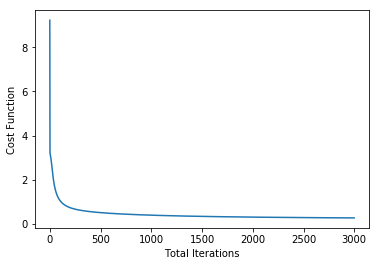

In [22]:
inputLayerSize=400
hiddenLayerSize=25

alpha=1
lmbda=0.5
epoch=3000
batchSize=xTrain.shape[0]

theta1,theta2=gradientDescent(xTrain,yTrain,inputLayerSize,hiddenLayerSize,alpha,lmbda,epoch,batchSize)

##### Calculating TRAIN accuracy

In [23]:
h=predictNN(theta1,theta2,xTrain)
accuracy=calculateAccuracy(h,yTrain)
print(f'TRAIN ACCURACY : {accuracy:.3f}%')

TRAIN ACCURACY : 98.644%


##### Calculating TEST accuracy

In [24]:
h=predictNN(theta1,theta2,xTest)
accuracy=calculateAccuracy(h,yTest)
print(f'TEST ACCURACY : {accuracy:.3f}%')

TEST ACCURACY : 94.000%


### (Optional) Classifying Custom Handwritten Digits

**RGB to YIQ Colorspace conversion**
<img src='images/conversion.png'>

In [25]:
def getImageMatrix(fileName,cropPercentage=0):
    '''
       Usage: 
       getImageMatrix('myDigit.jpg', 100, -1);

       First parameter: Image file name
             Could be bigger than 20 x 20 px, it will
             be resized to 20 x 20. Better if used with
             square images but not required.
 
       Second parameter: cropPercentage (any number between 0 and 100)
             0  0% will be cropped (optional, no needed for square images)
            50  50% of available croping will be cropped
           100  crop all the way to square image (for rectangular images)
 
       Third parameter: rotStep
            -1  rotate image 90 degrees CCW
             0  do not rotate (optional)
             1  rotate image 90 degrees CW
    '''
    # Read as RGB Image
    imageRGB=Image.open(fileName).convert('RGB')
    imageRGB=np.asarray(imageRGB)
    imageRGB=imageRGB/255
    # Convert to NTSC Image (YIQ)
    transfromationMat=np.array([
        [0.299,0.587,0.114],
        [0.596,-0.275,-0.321],
        [0.212,-0.523,0.311]
    ])
    imageYIQ=np.tensordot(transfromationMat,imageRGB,((1),(2))).T
    # Convert to grays keeping only luminance (y)
    imageBW=imageYIQ[:,:,0]
    # Get the size of image
    oldSize=imageBW.shape
    # Obtain a crop size towards centered square. cropDelta will be zero
    # for the already minimum dimension and if crop percentage is zero,
    # both the dimension are zero meaning that the original image will be 
    # intact to cropped image
    cropDelta=np.floor((oldSize-np.min(oldSize))*(cropPercentage/100))
    # Compute the desired final pixel size for the original image
    finalSize=oldSize-cropDelta
    # Compute each dimension origin for cropping
    cropOrigin=np.int16(np.floor(cropDelta/2))
    # Compute each dimension copying size
    copySize=np.int16(cropOrigin+finalSize)
    # Copy just the desired cropped image from the original B&W image
    croppedImage=imageBW[cropOrigin[0]:copySize[0],cropOrigin[1]:copySize[1]]
    # Resolution scale factor
    scale=np.array((20,20))/finalSize
    # Compute back the new image size
    newSize=np.int16(np.floor(np.multiply(scale,finalSize)))
    # Compute a re-sampled set of indices
    rowIndices=np.int16(np.round((np.array(range(1,newSize[0]+1))-0.5)/scale[0]+0.5))-1
    colIndices=np.int16(np.round((np.array(range(1,newSize[1]+1))-0.5)/scale[1]+0.5))-1
    # Copy just the indexed values from cropped image to get new image
    newImage=croppedImage[rowIndices,:]
    newImage=newImage[:,colIndices]
    # Invert black and white
    invertedImage=-newImage
    # Find min and max gray values in the image
    maxValue=invertedImage.max()
    minValue=invertedImage.min()
    # Compute the value range of actual grays
    delta=maxValue-minValue
    # Normalize grays between 0 and 1
    normImage=(invertedImage-minValue)/delta
    return imageRGB,normImage

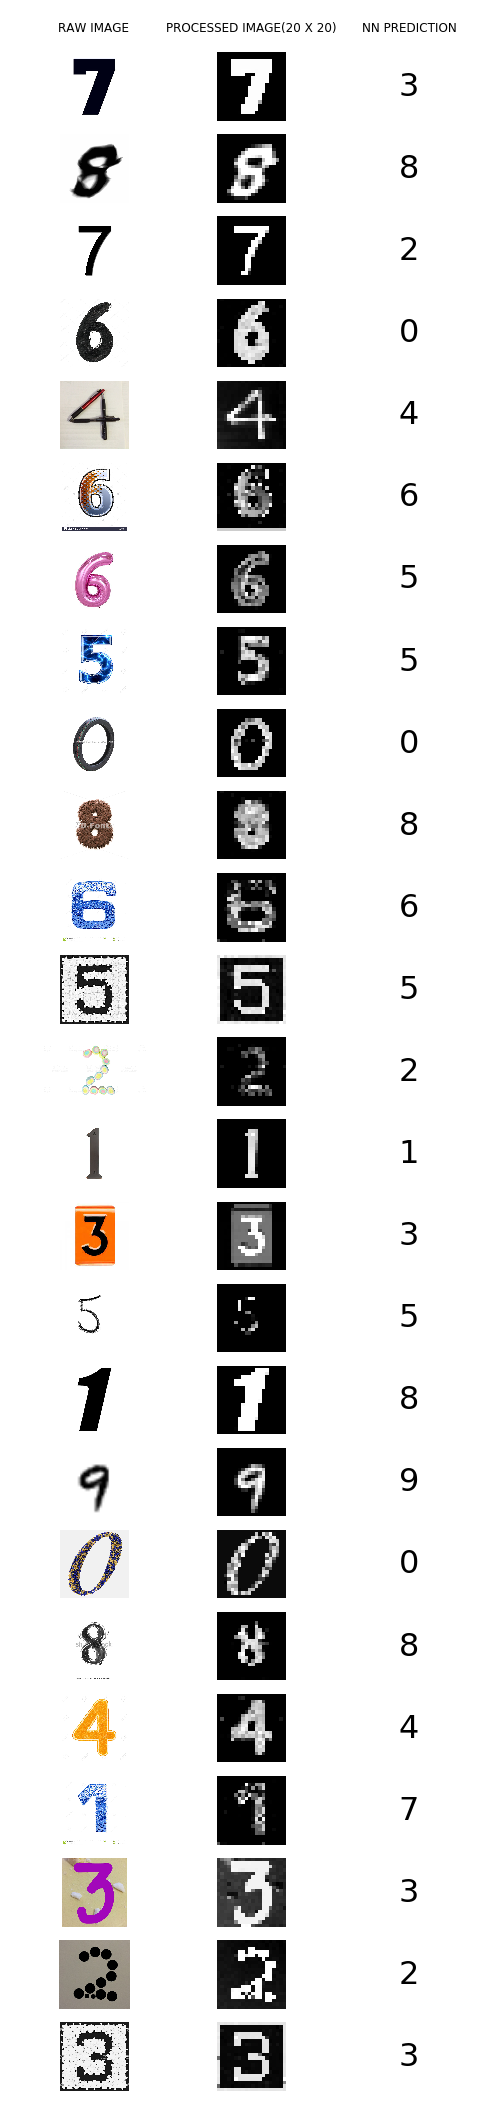

In [26]:
filePaths=glob.glob('./images/img_*')
np.random.shuffle(filePaths)

nrows=len(filePaths)
ncols=3
fig,ax=plt.subplots(nrows,ncols,figsize=(8,nrows*1.5))

for i in range(nrows):
    imgRGB,mat=getImageMatrix(filePaths[i],cropPercentage=100)
    prediction=predictNN(theta1,theta2,mat.reshape((1,400)))[0][0]
    # Setting the axis off
    for j in range(ncols):
        ax[i][j].axis('off')
    # Headers
    if i==0:
        ax[i][0].set_title('\nRAW IMAGE\n')
        ax[i][1].set_title('\nPROCESSED IMAGE({0} X {1})\n'.format(*mat.shape))
        ax[i][2].set_title('\nNN PREDICTION\n')
    # Plotting raw and processed image along with prediction
    ax[i][0].imshow(imgRGB,cmap='gray')
    ax[i][1].imshow(mat.T,cmap='gray')
    ax[i][2].text(0.5, 0.5,prediction,
                  horizontalalignment='center',
                  verticalalignment='center',
                  fontsize=32)

<img src="images/meme.jpg" width="600">